In [1]:
import astropy.units as u
import numpy as np
import gala.potential as gp
import gala.dynamics as gd
from gala.dynamics import mockstream as ms
from gala.units import galactic
from astropy.coordinates import SkyCoord, Distance
#import popsims
import matplotlib.pyplot as plt
#%matplotlib notebook
from tqdm import tqdm
from astropy.constants import G
#import HSS
from gala.units import galactic
import gala.coordinates as gc
import  h5py
import imageio
import seaborn as sns
import matplotlib as mpl
import matplotlib.animation as animation
import astropy.coordinates as astro_coord
sns.set_style("dark")
mpl.rc('xtick', labelsize=16) 
mpl.rc('ytick', labelsize=16) 
font = {'axes.titlesize'      : 'large',   # fontsize of the axes title
        'axes.labelsize'      : 'large', # fontsize of the x any y labels
        'size'   : 16}
#plt.style.use('dark_background')
import itertools
#paths
path_plot = '/users/caganze/research/stellarstreams/figures/stream/'
path_data = '/users/caganze/research/stellarstreams/data/stream/'

#coords standards
_ = astro_coord.galactocentric_frame_defaults.set('v4.0')

#galactocentric reference frame
v_sun = astro_coord.CartesianDifferential([11.1, 220 + 24.0, 7.25]*u.km/u.s)
galcen_frame =astro_coord.Galactocentric(galcen_distance=8.*u.kpc,
                                    galcen_v_sun=v_sun)

#potential

pot=gp.MilkyWayPotential()
H = gp.Hamiltonian(pot)

STREAM_CONFIGURATION={'stream_coord':gd.PhaseSpacePosition(SkyCoord(x=0*u.kpc, y=0* u.kpc,z=10*u.kpc, \
                                                v_x=150*u.km/u.s, v_y=150*u.km/u.s, v_z=0*u.km/u.s,\
                                                 frame=galcen_frame).cartesian),
                      'col_angle':  np.pi/10,
                      'mstream': 14404*u.Msun, #this is from Bonaca et al.
                     'tfinal': 3000*u.Myr,
                      'tcollision': 200*u.Myr, 
                      'textra': 30*u.Myr,
                      'dt': 1*u.Myr,
                      'nsteps':200,
                      'nstars': 2000,
                      'file_prefix': 'test' }


def plot_stream(mock_st, mock_pos, collision_pos, collision_vel, halo_vel, filename, alpha=0.5):
    #visualize 
    fig, (ax, ax1, ax2)=plt.subplots(figsize=(12, 4), ncols=3)

    ax.scatter(mock_st.x, \
               mock_st.y,  s=1, alpha=alpha, c='k')

    ax.scatter(mock_pos.x, mock_pos.y, s=100, c='r')
    ax.scatter(collision_pos.value[0], collision_pos.value[1], s=200, c='y', marker='x')

   
    ax1.scatter(mock_st.x, \
               mock_st.z,  s=1, alpha=alpha, c='k')
    ax1.scatter(mock_pos.x, mock_pos.z, s=100, c='r')
    ax1.scatter(collision_pos.value[0], collision_pos.value[-1], s=200, c='y', marker='x')


    ax2.scatter(mock_st.y, \
               mock_st.z,  s=1, alpha=alpha, c='k')
    ax2.scatter(mock_pos.y, mock_pos.z, s=100, c='r')
    ax2.scatter(collision_pos.value[1], collision_pos.value[-1], s=200, c='y', marker='x')

    V = np.array([[collision_vel.value[0], collision_vel.value[-1]], [halo_vel[0].value, halo_vel[-1].value]])
    origin =[np.array([collision_pos.value[0], collision_pos.value[-1]]), \
    np.array([collision_pos.value[0], collision_pos.value[-1]])]
 

    ax1.quiver(*origin, V[:,0], V[:,1], color=['b', 'b'], scale=21)
    #ax1.quiver((collision_pos.value[0], collision_pos.value[-1]), V[1], color='b', scale=21)

    #ax2.

    #ax2.scatter(mock_st.to_coord_frame(astro_coord.ICRS,  galactocentric_frame=galcen_frame).ra, \
    #           mock_st.to_coord_frame(astro_coord.ICRS, galactocentric_frame=galcen_frame).dec,  s=1, alpha=alpha)
    #ax2.scatter(mock_pos.to_coord_frame(astro_coord.ICRS, galactocentric_frame=galcen_frame).ra, \
    #            mock_pos.to_coord_frame(astro_coord.ICRS, galactocentric_frame=galcen_frame).dec, s=100, c='r')

    ax2.set_xlabel('y (kpc)', fontsize=16)
    ax2.set_ylabel('z (kpc)', fontsize=16)
    ax.set_xlabel('x (kpc)', fontsize=16)
    ax.set_ylabel('y (kpc)', fontsize=16)
    ax1.set_xlabel('x (kpc)', fontsize=16)
    ax1.set_ylabel('z (kpc)', fontsize=16)
    
    #ax2.invert_xaxis()
    #ax.set(xlim=[245, 255], ylim=[-10, 2.5])
    plt.tight_layout()
    plt.savefig(path_plot +'/unpeturbed'+filename+'.jpeg')

def generate_stream_and_perturber(mass, prog_w0, timedict,  nbody=None, output_every=None,
                                  output_filename=None):
    """
    Input: mass of the progenitor, its position, other mockstream generator kwrargs
    Returns: final stream and its position and velocity
    
    Calls mockstream generator
    
    """
    NSTARS=STREAM_CONFIGURATION['nstars']

    df = ms.FardalStreamDF()
    prog_mass = mass * u.Msun
     
    gd1_pot = gp.PlummerPotential(m=mass, b=4*u.pc, units=galactic)

    gen = ms.MockStreamGenerator(df, H,progenitor_potential=gd1_pot )

    return gen.run(prog_w0, prog_mass, nbody=nbody,\
                   output_every=output_every, output_filename= output_filename, \
                check_filesize=True, overwrite=True, n_particles=int(NSTARS/len(timedict['t'])),  progress=True, **timedict)

def run_stream_and_subhalo(halo_mass, stream_mass, halo_r, halo_pos, stream_pos, timedict,
                           filename='mockstream',
                            output_every=1, potential_type='plummer'):
    """
    runs a subhalo and a stream 
    
    returns the progenitor position and the final stream
    
    Takes in the parameters of the subhalos
    
    """
    
    #create a plummer sphere 
    point_potential=gp.PlummerPotential(halo_mass*u.Msun,  halo_r*u.pc, units=galactic)
    
    #if potential_type
    if  potential_type.lower()=='hern':
        point_potential=gp.HernquistPotential(halo_mass*u.Msun,  halo_r*u.pc, units=galactic)
        
    #create an Nbody potential object
    Massive_body=gd.DirectNBody(halo_pos, [point_potential], external_potential=pot)
    
    return  generate_stream_and_perturber(stream_mass,  stream_pos, timedict, \
                                      nbody=Massive_body,
                                    output_every=output_every, \
                                    output_filename=path_data+'/'+filename+'.h5')

def plot_orbit_history(filename, coll_pos):
    bodies, stream=read_stream_file(filename+'.h5')
    
    body0=bodies['pos'][:,:,0 ]
    body1=bodies['pos'][:,:,1 ]

    collision_xyz= coll_pos.xyz.value

    dx=((  body0[0]-  (stream['pos'][0]).T)**2+\
        (  body0[1]-  (stream['pos'][1]).T)**2+\
        (  body0[-1]-  (stream['pos'][-1]).T)**2)**0.5

    #d_center=((  body0[0]-  body1[0])**2+\
    #    (  body0[1]-  body1[1])**2+\
    #   (  body0[-1]-  body1[-1])**2)**0.5

    d= ((  collision_xyz[0]-  body1[0])**2+\
        (  collision_xyz[1]-  body1[1])**2+\
       (  collision_xyz[-1]-  body1[-1])**2)**0.5




    #print ('----------------minimum distance {} kpc---------'.format(np.nanmin(d)))
    
    fig, ax=plt.subplots(figsize=(10, 6))
    plt.plot(np.arange(len(dx.T)), np.log10(abs(dx.T*1000)), c='#0074D9', alpha=1, ms=10)
    ax.set_ylabel('Log Separation (Subhalo Strean) (pc) ', fontsize=16)
    ax.set_title('minimum distance {} pc '.format(int(np.nanmin(d*1000))))

    ax.set_xlabel('timestep ', fontsize=16)
    plt.legend()
    plt.savefig(path_plot +'/history_'+filename+'.jpeg')
    
    return 

def read_stream_file(filename):
    """
    reads in a saved stream run 
    returns the subhalo, progenitor and stream
    """
    print (filename)
    f = h5py.File(path_data+'/'+filename, mode='r')
    
    body=f['nbody']
    stream_cont=f['stream']
    
    #f.close()
    return body, stream_cont

def plot_stream_and_body(idx, stream_cont, body, time_dict,  coll_pos):
    
    body_pos=body['pos']
    stream_pos=stream_cont['pos']

    print (body['vel'])
    stream_vel=stream_cont['vel']
    body_vel=body['vel'][:,:,0]

    body_total_vel=(body_vel[0][idx]**2+body_vel[1][idx]**2+body_vel[-1][idx]**2)**0.5
    print (np.shape(body_total_vel))

    stream_velz=np.log10((((stream_vel[0][idx]-body_vel[0][idx])**2+ \
    (stream_vel[1][idx]-body_vel[1][idx])**2+ \
    (stream_vel[-1][idx]-body_vel[-1][idx])**2)**0.5)/body_total_vel)

    #vz only
    stream_velz=np.log10((abs(abs(stream_vel[-1][idx])-abs(np.nanmedian(stream_vel[-1][idx])))/(abs(np.nanmedian(stream_vel[-1][idx])))))

    print (np.nanmin(stream_velz), np.nanmax(stream_velz))
    #breakpoint()
    
    if 't' in time_dict.keys():
        t=time_dict['t'][idx]
    else:
        t= time_dict['tmin']+20*idx*time_dict['dt']
    t=t.to(u.Myr)
    
    fig, (ax, ax1, ax2)=plt.subplots(figsize=(12, 4), ncols=3)
    
    fig.suptitle('T = {:.0f} '.format(t ), fontsize=16)

    
    ax.scatter(stream_pos[0][idx], stream_pos[1][idx], s=1, c='k', alpha=0.5, vmin=-5, vmax=1, cmap='cividis')
    ax.scatter(body_pos[0][idx], body_pos[1][idx],  s=100, alpha=0.5, c=['b', 'r'], label='Particle')
    
    
    ax1.scatter(stream_pos[0][idx], stream_pos[-1][idx],  s=1, c='k', alpha=0.5, vmin=-5, vmax=1,cmap='cividis')
    ax1.scatter(body_pos[0][idx], body_pos[-1][idx],  s=100, alpha=0.5, c=['b', 'r'], label='Particle')
    
    c=ax2.scatter(stream_pos[1][idx], stream_pos[-1][idx],  s=1, c='k', alpha=0.5, vmin=-5, vmax=1, cmap='cividis')
    ax2.scatter(body_pos[1][idx], body_pos[-1][idx],  s=100, alpha=0.5, c=['b', 'r'], label='Particle')
    
   
    

    ax.minorticks_on()
    ax1.minorticks_on()

    #ax1.legend(fontsize=14)
    ax.set(xlabel='x (pc)', ylabel='y (pc)')
    ax1.set(xlabel='x (pc)', ylabel='z (pc)')
    ax2.set(xlabel=r'y (pc)', ylabel='z (pc)')
    
    #cbar= plt.colorbar(c)
    #cbar.ax.set(ylabel='(V-Vprog)/Vprog')
    x=stream_pos[0][idx]
    y=stream_pos[1][idx]
    z=stream_pos[-1][idx]
    xlim=[np.nanmean(x)-5*np.nanstd(x), np.nanmean(x)+5*np.nanstd(x)]
    ylim=[np.nanmean(y)-5*np.nanstd(y), np.nanmean(y)+5*np.nanstd(y)]
    zlim=[np.nanmean(z)-5*np.nanstd(z), np.nanmean(z)+5*np.nanstd(z)]

    #ax.set(xlim= xlim, ylim=ylim)
    #ax1.set(xlim=xlim, ylim=zlim)
    #ax2.set(xlim=ylim, ylim=zlim)
    
    plt.tight_layout()

    plt.show(block=False)
    plt.pause(0.3)
    plt.close()

    
    
    # IMPORTANT ANIMATION CODE HERE
    # Used to keep the limits constant

    # Used to return the plot as an image rray
    fig.canvas.draw()       # draw the canvas, cache the renderer
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))




    return image

def rotate(x, y, ang):
    """
    Angle must be in radians
    """
    
    #rotation matrix
    r=[[np.cos(ang), -np.sin(ang)],
       [np.sin(ang), np.cos(ang)]]
    
    c=(0, 0)
    
    i=np.identity(2)
    
    mat=np.matrix([[r[0][0], r[0][1], np.dot(i-r, c)[0]],
                   [r[1][0], r[1][1], np.dot(i-r, c)[1]],
                   [0., 0., 1.]])

    z=np.ones_like(x)
    
    rotated=np.array(np.dot(mat, np.array([x, y, z])))
    
    return rotated[0], rotated[1] 
def run_one_stream(vhalo, mhalo, halo_r, visualize_collision=False, \
                   angle=np.pi/6, filename=None,  add_more_stars=False, nadd=1000):
        
        #integrate the orbit back
        st_pos= STREAM_CONFIGURATION['stream_coord']
        dt= STREAM_CONFIGURATION['dt']
        tfinal=STREAM_CONFIGURATION['tfinal']
        mstream=STREAM_CONFIGURATION['mstream']
        tcollision=STREAM_CONFIGURATION['tcollision']
        NSTARS=STREAM_CONFIGURATION['nstars']
        textra=STREAM_CONFIGURATION['textra']
        NSTEPS=STREAM_CONFIGURATION['nsteps']
        NSTARS=STREAM_CONFIGURATION['nstars']

        orbit_tf=gp.Hamiltonian(pot).integrate_orbit(st_pos, dt=-dt, t1=0*u.Gyr, t2=-tfinal)
        
        #generate orbits at -tmax years
        pos_tf=gd.PhaseSpacePosition(pos=orbit_tf.xyz[:,-1], vel=orbit_tf.v_xyz[:,-1])
        
        gd1_pot = gp.PlummerPotential(m=mstream, b=4*u.pc, units=galactic)

        #generate stream at -tmax+tcollision
        df = ms.FardalStreamDF()
        gen = ms.MockStreamGenerator(df, H, progenitor_potential=gd1_pot)
        
        mock_st, mock_pos=gen.run( pos_tf, mstream, dt=dt, t1=0*u.Myr, t2= tcollision ,\
                                            nbody=None, n_particles=int(NSTARS/((tcollision/(dt)).value)), progress=True,   release_every=1)


        #visualize point of stream + partcile collisitions
        if True:
            
           
            #print (tcollision)
            #for 50 kpoc
            #col_idx=np.random.choice(np.arange(len(mock_st.y))[np.logical_and.reduce([mock_st.x.value>42.7, \
            #                                                                               mock_st.x.value<43, 
            #                                                                               mock_st.z.value <43 ])])
            #for 30 kpoc
            #col_idx=np.random.choice(np.arange(len(mock_st.y))[np.logical_and.reduce([mock_st.x.value>0., \
            #                                                                               mock_st.x.value<0.1, 
            #                                                                               mock_st.z.value <-15 ])]
            
            subhalo_minus_stream=((mock_st.x.value-mock_pos.x.value)**2+\
                                (mock_st.y.value-mock_pos.y.value)**2+\
                                (mock_st.z.value-mock_pos.z.value)**2)**0.5
                                
            

            col_idx=np.random.choice(np.arange(len(mock_st.y))[np.logical_and.reduce([subhalo_minus_stream <0.6,
                                                                                     subhalo_minus_stream>0.5])])
            
            print ('col idx', col_idx)
            collision_pos=mock_st.xyz[:
                                      , col_idx]
            print ('stream position {}'.format(mock_st.xyz[:
                                      , col_idx]))
            print ('stream velocity {}'.format(mock_st.v_xyz[:
                                      , col_idx]))
            
            
            fig, ax=plt.subplots(ncols=2, figsize=(12, 4))
            
            ax[0].scatter(mock_st.x, mock_st.z, s=10)
            ax[1].scatter(mock_st.y, mock_st.z, s=10)

            ax[0].scatter(collision_pos[0], collision_pos[-1],\
             s=100, marker='x')
            ax[1].scatter(collision_pos[1], collision_pos[-1],s=100, marker='x')
            ax[0].set(xlabel='x', ylabel='z')
            ax[1].set(xlabel='y', ylabel='z')
            plt.show()
         
        #collision position for (x=10, y=10) kpc
        #collision_pos=STREAM_CONFIGURATION['col_position']
        #stream_velocity=STREAM_CONFIGURATION['col_velocity']
        
        collision_pos=mock_st.xyz[:
                                      , col_idx]
        stream_velocity=mock_st.v_xyz[:
                                      , col_idx].value

        halo_velocity= np.concatenate(list(rotate(np.array([stream_velocity[0]]),  \
            np.array([stream_velocity[-1]]), -angle)))*u.km/u.s

        #normalize it and multiply it by the expected halo
        norm_vel= vhalo/(np.nansum(halo_velocity.value**2)**0.5)
        
       

        #plot a visualization of the stream and subhalo
        #plot_stream(mock_st,  mock_pos,   collision_pos,  stream_velocity*u.km/u.s/100, [halo_velocity[0]/100, 0, halo_velocity[-1]/100], filename)

        full_halo_vel=[halo_velocity[0].value*norm_vel, 0, halo_velocity[-1].value*norm_vel]*u.km/u.s
        #
        #average velocity of 100 points near collision
        #forget the angle, compute the velocity difference between stars at an average positions
        avg_vel=np.nanmedian([mock_st.v_xyz[:
                                      , idx] for idx in range(col_idx-50, col_idx+50)], axis=0)
        avg_pos=np.nanmedian([mock_st.v_xyz[:
                                      , idx] for idx in range(col_idx-50, col_idx+50)], axis=0)
        
        print ('avg velocity')
        print (avg_vel)
        
        #compute vz such that the difference with the subhalo velocity is tiny
        vz= (vhalo**2- avg_vel[0]**2- avg_vel[1]**2)**0.5-avg_vel[-1]
        #full_halo_vel=[0, 0, vz]*u.km/u.s
        
    
        #compute the phase space position for collision
        print ('--------------------------------------')
        print ('halo impact position {}'.format(collision_pos))
        print ('halo impact velocity {} '.format(full_halo_vel))
        print ('halo mass {:.2e} '.format(mhalo))
        print ('relative velocity {}')

        collision_phase_space_pos=gd.PhaseSpacePosition(pos=collision_pos,
                                        vel=full_halo_vel)

        #the halo  to a time  equal to collision time 
        collision_orbit= gp.Hamiltonian(pot).integrate_orbit(collision_phase_space_pos,  dt=-dt,\
                                                             t1=0.*u.Myr, t2=-tcollision)

        #integrate both the halo and stream forward up a few nudges after collision plus some nudge 
        time_dict= {'t':np.linspace(0*u.Myr, tcollision+textra, NSTEPS)}

        #integrate subhalo and stream in time 
        collision_halo_pos=gd.PhaseSpacePosition(pos=collision_orbit.xyz[:,-1],
                                      vel=collision_orbit.v_xyz[:,-1])

        stream_pos_t0=gd.PhaseSpacePosition(pos=orbit_tf[-1].xyz,
                                      vel=orbit_tf[-1].v_xyz)

        col_stream, col_pos =  run_stream_and_subhalo(mhalo, mstream, halo_r, collision_halo_pos, \
                                                   stream_pos_t0 ,  time_dict,
                                   filename=filename,   potential_type='hern')
        #plot the collision
        plot_orbit_history(filename,   collision_phase_space_pos)

        #visualize collision avoid plotting too many gifs
        steps=np.arange(30)
        ratio=1
        if visualize_collision:
            while len(steps)>20:
                idxs=np.logical_and(time_dict['t'] >tcollision-textra/ratio, time_dict['t'] <tcollision+textra/ratio)
                steps=np.arange(len(time_dict['t'].value))[idxs]
                ratio += 1
               

            kwargs_write = {'fps':1, 'quantizer':'nq'}
            bdy_all, stream_all=read_stream_file(filename+'.h5')
            _= imageio.mimsave(path_plot+'/'+ filename+'vzonly.gif',\
                               [ plot_stream_and_body(i, stream_all, bdy_all,  time_dict,\
                                collision_pos) for i in \
                                                 steps], \
                               fps=5)

        #integrate in time for the remaining time until to reach total of tfinal
        time_dict_total={'t1': 0*u.Myr, 't2': tfinal-(tcollision+textra), 'dt': dt}

        #integrate individual stars
        final_col_stream_pos=gd.PhaseSpacePosition(pos=col_stream.xyz,
                                                   vel=col_stream.v_xyz)
        final_progen_pos=gd.PhaseSpacePosition(pos=col_pos.xyz,
                                                   vel=col_pos.v_xyz)

        old_stream_orbit=gp.Hamiltonian(pot).integrate_orbit(final_col_stream_pos,  **time_dict_total)
        final_prog_orbit=gp.Hamiltonian(pot).integrate_orbit(final_progen_pos,  **time_dict_total)

        #round it approximate to avoid issue with floating points
        use_pos= gd.PhaseSpacePosition(pos=final_progen_pos[0].xyz, \
            vel=final_progen_pos[0].v_xyz)
        print (use_pos)
        print (time_dict_total)

        #generate additional stars at the center 
        mock_st_additional, _=gen.run( use_pos, mstream,  **time_dict_total,
                                            nbody=None, progress=True, \
                                            n_particles=int(NSTARS/((tcollision/(dt)).value)),   \
                                      release_every=1)
        #add streams at final position
        #combine old a new
        #save and plot out the final stream
        final_stream_coord=SkyCoord(x=old_stream_orbit.x[-1],
                                        y=old_stream_orbit.y[-1],
                                        z=old_stream_orbit.z[-1], 
                                        v_x=old_stream_orbit.v_x[-1], 
                                        v_y=old_stream_orbit.v_y[-1],
                                        v_z=old_stream_orbit.v_z[-1], 
                               frame=galcen_frame)
        
        if add_more_stars:
            final_stream_coord=SkyCoord(x=np.concatenate([old_stream_orbit.x[-1],  mock_st_additional.xyz[0]]),\
                                        y=np.concatenate([old_stream_orbit.y[-1], mock_st_additional.xyz[1]]),\
                                        z=np.concatenate([old_stream_orbit.z[-1], mock_st_additional.xyz[-1]]),\
                                        v_x=np.concatenate([old_stream_orbit.v_x[-1], mock_st_additional.v_xyz[0]]),\
                                        v_y=np.concatenate([old_stream_orbit.v_y[-1], mock_st_additional.v_xyz[1]]),\
                                        v_z=np.concatenate([old_stream_orbit.v_z[-1], mock_st_additional.v_xyz[-1]]),\
                               frame=galcen_frame)


        final_prog_coord=SkyCoord(x=final_prog_orbit.x[-1], y=final_prog_orbit.y[-1],  \
                                 z=final_prog_orbit.z[-1], v_x=final_prog_orbit.v_x[-1], \
                                 v_y= final_prog_orbit.v_y[-1], v_z=final_prog_orbit.v_z[-1], \
                                 frame=galcen_frame)

        #visualize final stream
        #fig, anim = final_stream_orbit.animate(stride=20, 
        #                   FuncAnimation_kwargs=dict(interval=10), marker_style={'ms':2}, underplot_full_orbit=False)

        #anim.save(path_plot+'/collision_orbits_{}.gif'.format(filename), dpi=80, writer='imagemagick')




        #visualize in the mikly 
        fig, (ax, ax1)=plt.subplots(figsize=(12, 4), ncols=2)

        ax.scatter(final_stream_coord.x, \
        final_stream_coord.y,  s=0.2, alpha=1,  marker='.', c='k')
        ax.scatter(final_prog_coord.x[0], \
                   final_prog_coord.y[0],  s=100, c='b')
        ax.set(xlabel='x (kpc)',
               ylabel='y (kpc)')
        ax1.scatter(final_stream_coord.y, \
                   final_stream_coord.z,  s=0.2, alpha=1,  marker='.', c='k')
        ax1.scatter(final_prog_coord.y[0], \
                   final_prog_coord.z[0],  s=100, c='b')
        ax1.set(xlabel='y (kpc)',
               ylabel='z (kpc)')
        #ax1.invert_xaxis()
        #fig.suptitle('halo mass = {:.3e} Msun'.format(mhalo), fontsize=16)

        #plt.tight_layout()
        #plt.savefig(path_plot +'/gap'+filename+'.jpeg')

        final_data={'stream': final_stream_coord, 'prog': final_prog_coord}
        #save the data
        np.save(path_data+'/{}.npy'.format(filename), final_data)

In [2]:
#compute scale radius of subhalo
mhalo=1e6
#rhalo=1005*((mhalo/10**8)**0.5)
rhalo=0.1

Integrating orbits:  100%col idx 183
stream position [ 4.93116199  4.91594354 -8.01330972] kpc
stream velocity [-0.11370313 -0.11395182 -0.13727555] kpc / Myr


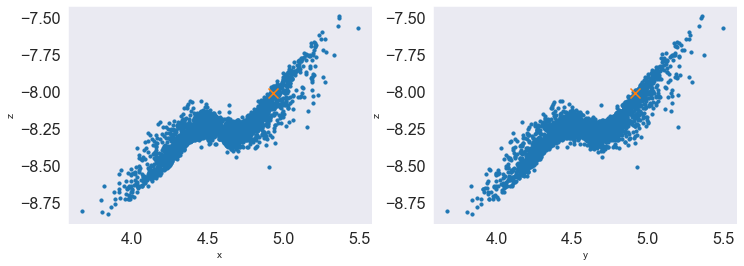

avg velocity
[-0.11803674 -0.11778221 -0.12797233]
--------------------------------------
halo impact position [ 4.93116199  4.91594354 -8.01330972] kpc
halo impact velocity [-77.01303207   0.          63.78865801] km / s 
halo mass 1.00e+06 
relative velocity {}
Integrating orbits:  100%test.h5


No handles with labels found to put in legend.


test.h5
<HDF5 dataset "vel": shape (3, 200, 2), type "<f8">
()
-4.649748633277392 -0.8306545035818268


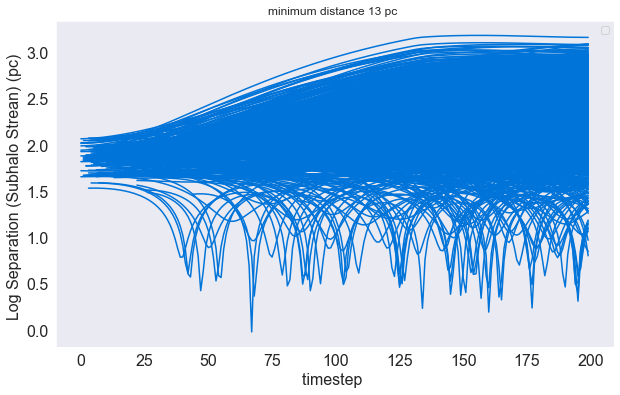

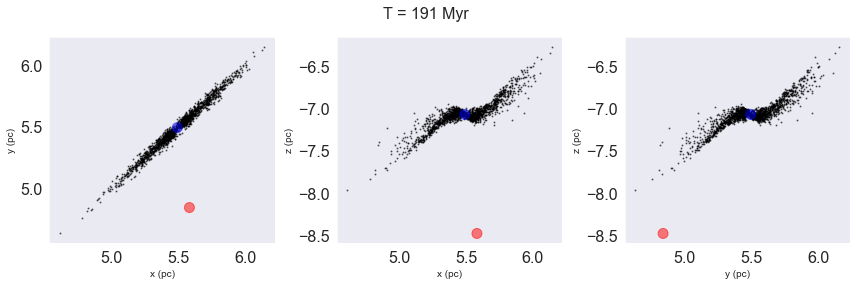

<HDF5 dataset "vel": shape (3, 200, 2), type "<f8">
()
-4.831432853599101 -0.8108003700837381


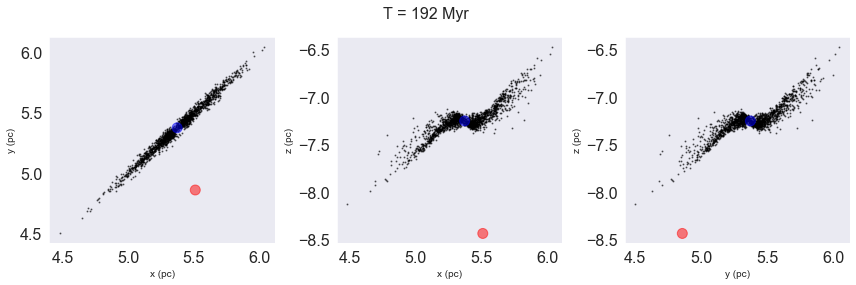

<HDF5 dataset "vel": shape (3, 200, 2), type "<f8">
()
-4.863776976778672 -0.7911095415500418


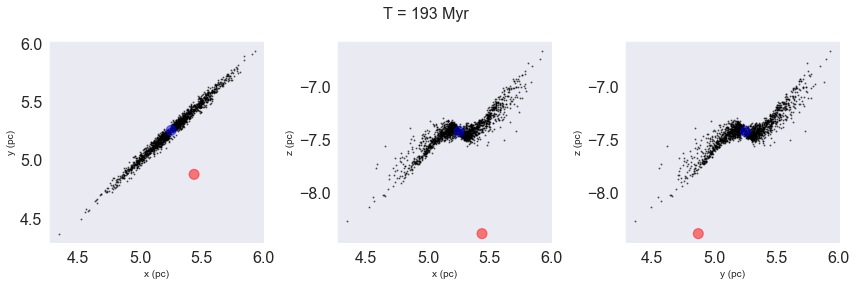

<HDF5 dataset "vel": shape (3, 200, 2), type "<f8">
()
-4.185299588736457 -0.7723320244980582


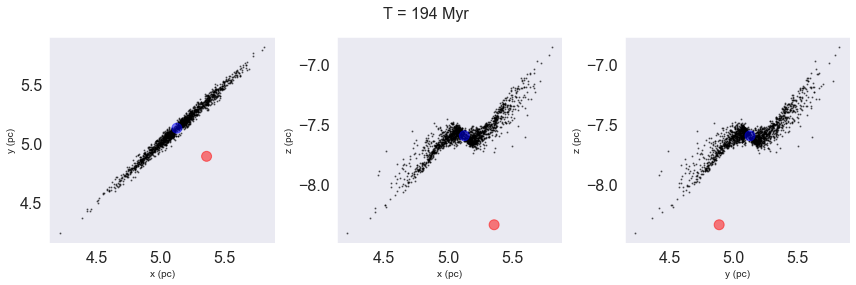

<HDF5 dataset "vel": shape (3, 200, 2), type "<f8">
()
-4.760501198528944 -0.7528324634945113


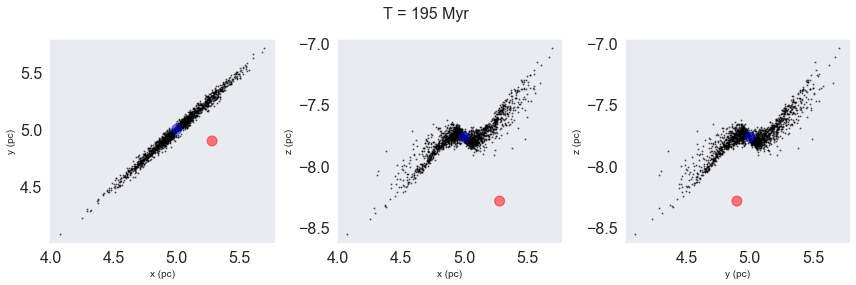

<HDF5 dataset "vel": shape (3, 200, 2), type "<f8">
()
-4.590414574466112 -0.7323152173482252


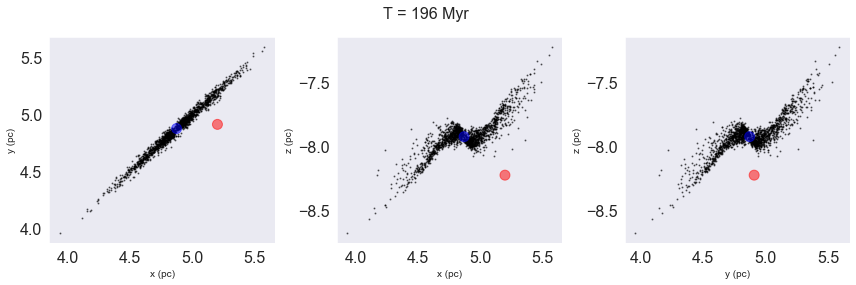

<HDF5 dataset "vel": shape (3, 200, 2), type "<f8">
()
-5.112342171724683 -0.7118851817765931


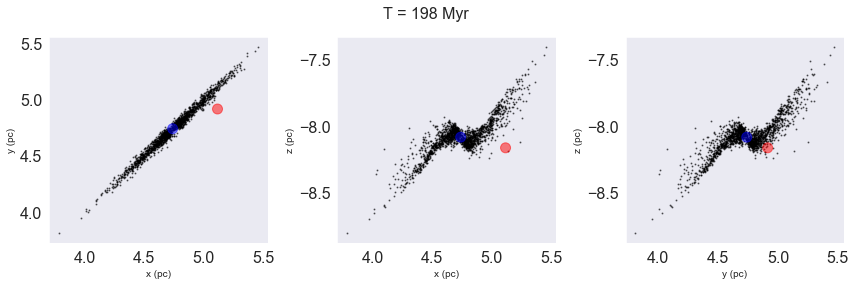

<HDF5 dataset "vel": shape (3, 200, 2), type "<f8">
()
-4.635992811132601 -0.6913681106720513


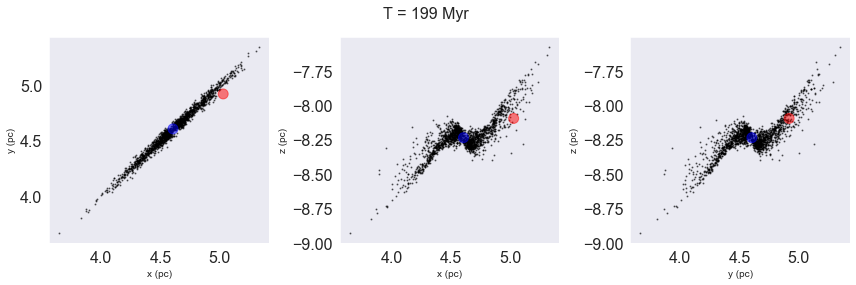

<HDF5 dataset "vel": shape (3, 200, 2), type "<f8">
()
-4.982563322909535 -0.6704660496669493


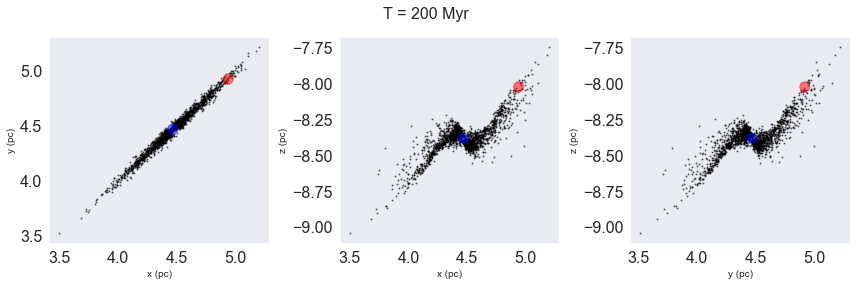

<HDF5 dataset "vel": shape (3, 200, 2), type "<f8">
()
-4.866431907722084 -0.6488372724997916


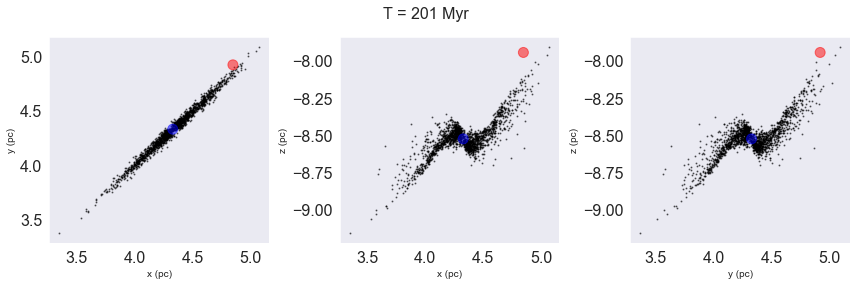

<HDF5 dataset "vel": shape (3, 200, 2), type "<f8">
()
-4.042605604225103 -0.6270582030051736


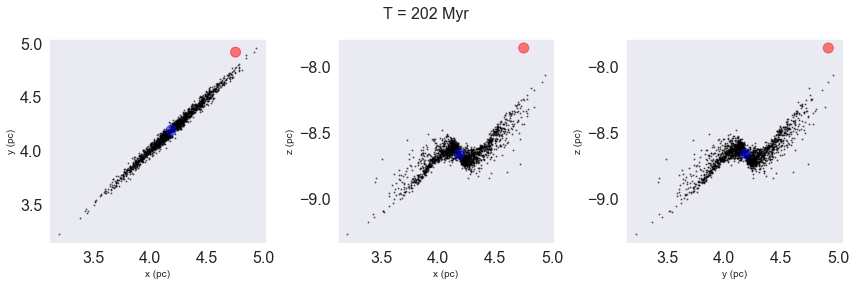

<HDF5 dataset "vel": shape (3, 200, 2), type "<f8">
()
-4.608869827435283 -0.604768580927715


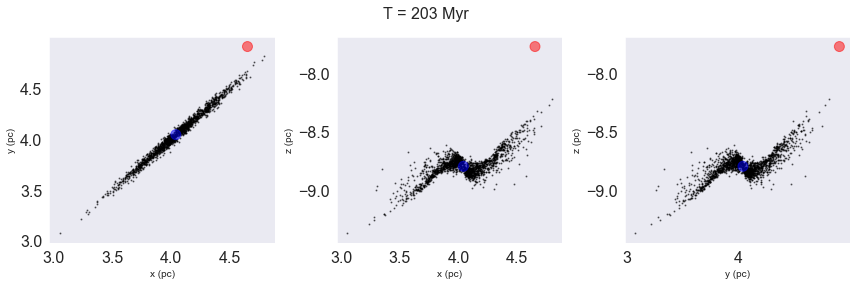

<HDF5 dataset "vel": shape (3, 200, 2), type "<f8">
()
-5.140153435632246 -0.5815558956270785


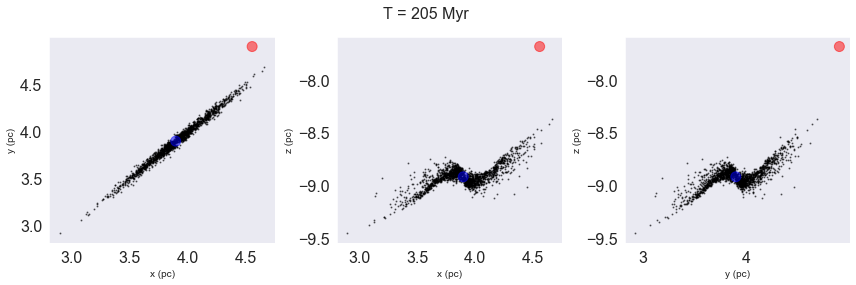

<HDF5 dataset "vel": shape (3, 200, 2), type "<f8">
()
-4.537066219479074 -0.5578363767930704


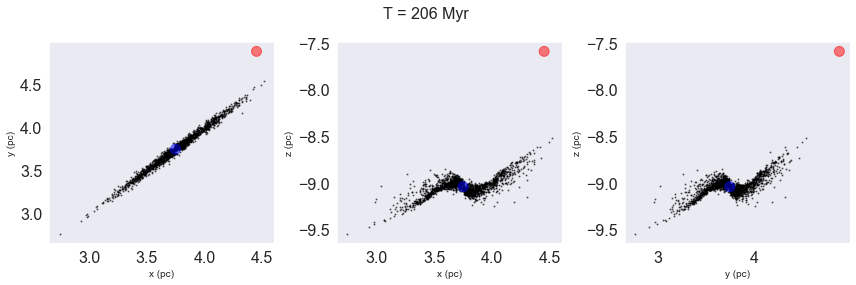

<HDF5 dataset "vel": shape (3, 200, 2), type "<f8">
()
-5.259568875635027 -0.5335459013765794


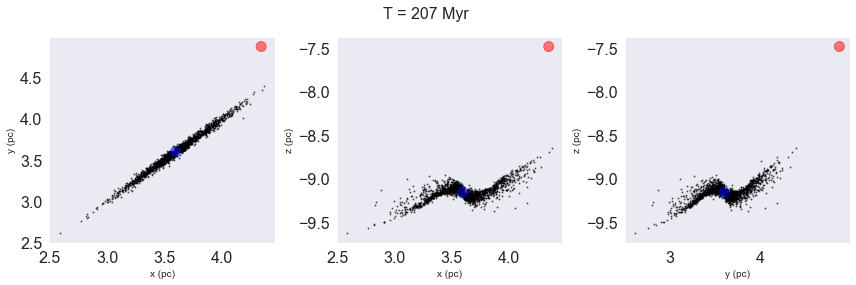

<HDF5 dataset "vel": shape (3, 200, 2), type "<f8">
()
-4.478852582305262 -0.5079652945059219


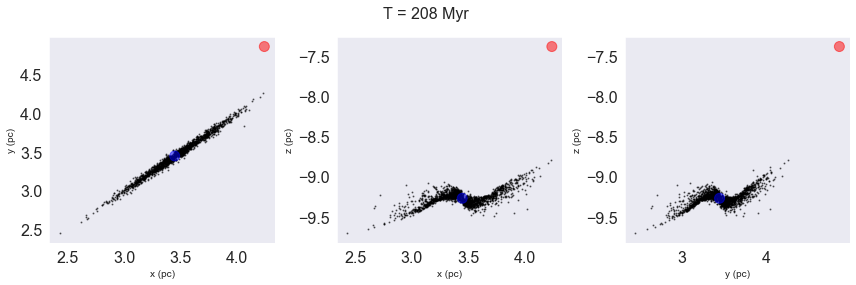

<HDF5 dataset "vel": shape (3, 200, 2), type "<f8">
()
-4.840611849668031 -0.4816245096136771


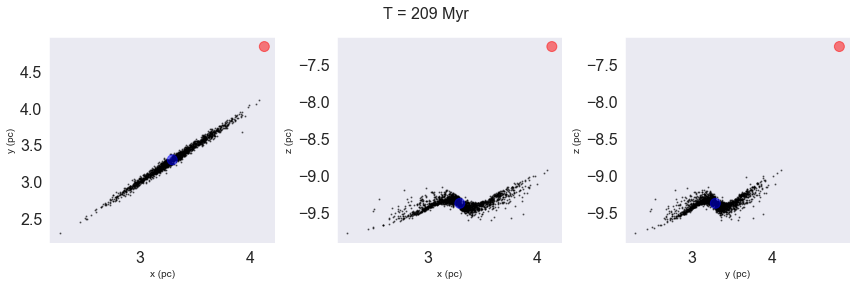

pos=(0.31426429, 0.31228555, -10.30788052) kpc
vel=(-0.14860511, -0.14864926, 0.0006602) kpc / Myr
{'t1': <Quantity 0. Myr>, 't2': <Quantity 2770. Myr>, 'dt': <Quantity 1. Myr>}
Integrating orbits:  100%

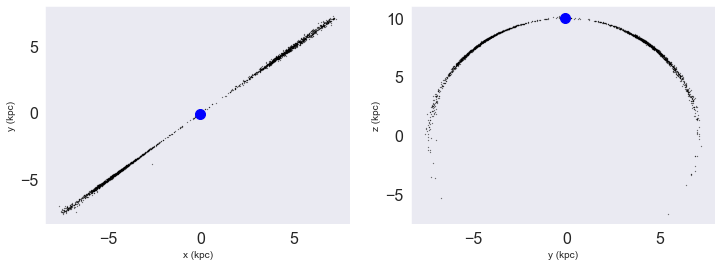

In [3]:
run_one_stream(100, mhalo,rhalo, visualize_collision=True, angle=np.pi/2, filename='test', add_more_stars=False)

In [4]:
gcfhj

NameError: name 'gcfhj' is not defined

In [ ]:
run_one_stream(100, mhalo,rhalo, visualize_collision=True, angle=np.pi/7, filename='test_addmore', \
               add_more_stars=True, nadd=5000)